In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
returns = pd.read_excel('PS2 Data.xlsx', sheet_name = 'Constant duration ex returns')
returns.rename(columns={returns.columns[0]: 'Date'}, inplace=True)
returns.set_index('Date', inplace=True)
returns.dropna(inplace=True)


paryields = pd.read_excel('PS2 Data.xlsx', sheet_name = 'Par yields')
paryields.rename(columns={paryields.columns[0]: 'Date'}, inplace=True)
paryields.set_index('Date', inplace=True)
paryields.dropna(inplace=True)

In [3]:
cov_matrix = paryields.cov()

In [4]:
Lambda, Q = np.linalg.eig(cov_matrix)

In [5]:
Q_df = pd.DataFrame(Q, columns=cov_matrix.columns, index=cov_matrix.columns)

In [6]:
Sigma = np.dot(np.dot(Q, np.diag(Lambda)), Q.T)
#SIGNMA Should be the same as the covariance matrix. This was just a check

In [7]:
Q_df

,US#01,US#02,US#03,US#04,US#05,US#06,US#07,US#08,US#09,US#10
US#01,0.323977,0.652865,0.580973,-0.306991,0.176449,-0.024861,-0.053991,-0.046398,-0.014522,-0.001682
US#02,0.329072,0.389617,-0.129882,0.534526,-0.512553,0.224972,0.231781,0.255630,0.070222,-0.000254
US#03,0.327883,0.202854,-0.401713,0.257160,0.101852,-0.470909,-0.350925,-0.505867,-0.110547,0.020934
US#04,0.324550,0.052421,-0.406847,-0.087818,0.615987,-0.082879,0.343008,0.459091,0.062422,-0.007604
US#05,0.319585,-0.061927,-0.272102,-0.267355,0.040628,0.735539,-0.179587,-0.307044,0.027335,-0.280301
US#06,0.314013,-0.149998,-0.123083,-0.380947,-0.300859,-0.005362,-0.221473,0.223625,-0.226533,0.691162
US#07,0.309670,-0.220123,0.019538,-0.300960,-0.338527,-0.366263,-0.074699,0.122185,0.600104,-0.367845
US#08,0.306328,-0.273941,0.149461,-0.079031,-0.168042,-0.175863,0.358154,-0.055247,-0.683102,-0.381332
US#09,0.303946,-0.319149,0.264896,0.182376,0.129156,0.061530,0.466950,-0.455928,0.313627,0.396974
US#10,0.301755,-0.355499,0.369627,0.446668,0.254272,0.101177,-0.519000,0.309351,-0.039515,-0.070113


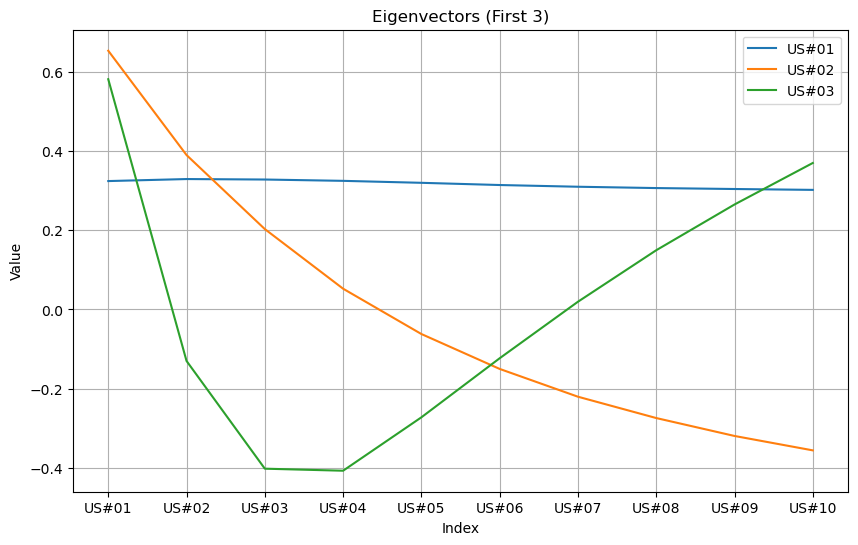

In [8]:

# Plot first 3 columns of Q_df on one chart
plt.figure(figsize=(10, 6))
for column in Q_df.columns[:3]:
    plt.plot(Q_df.index, Q_df[column], label=column)

plt.title('Eigenvectors (First 3)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Calculate total variance
total_variance = sum(Lambda)

# Calculate the percentage of variance explained by each eigenvector
variance_explained = [(Lambda / total_variance) * 100 for Lambda in Lambda[:3]]

# Report the percentages
for i, explained_variance in enumerate(variance_explained, start=1):
    print(f"Percentage of variance explained by eigenvector {i}: {explained_variance:.2f}%")


Percentage of variance explained by eigenvector 1: 97.97%
Percentage of variance explained by eigenvector 2: 1.97%
Percentage of variance explained by eigenvector 3: 0.06%


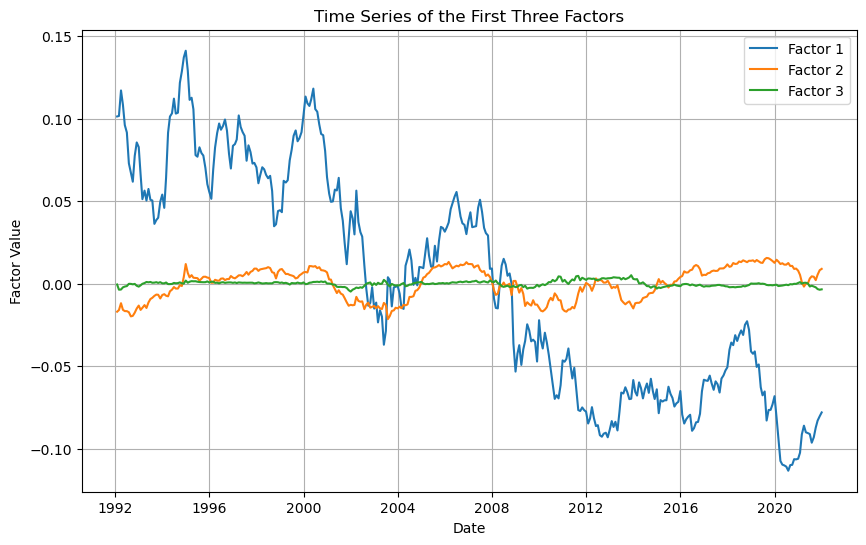

In [13]:
# Calculate the full sample average
full_sample_average = paryields.mean()

# Centered yields
centered_yields = paryields - full_sample_average

# Construct the factors
factors = centered_yields @ Q_df.iloc[:, :3]

# Plot the time series of the first three factors
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(factors.index, factors.iloc[:, i], label=f"Factor {i+1}")

plt.title('Time Series of the First Three Factors')
plt.xlabel('Date')
plt.ylabel('Factor Value')
plt.legend()
plt.grid(True)
plt.show()

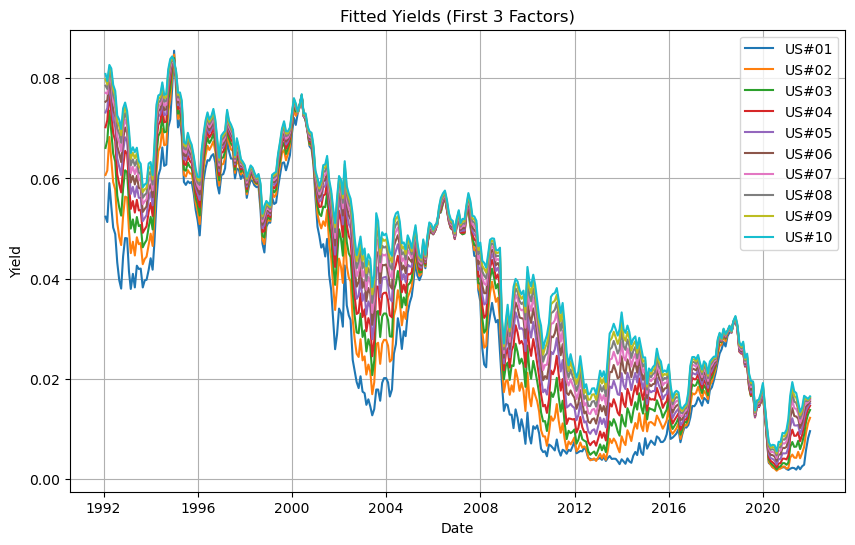

In [14]:
# Construct fitted yields by adding back the full sample average, only on the 1st 2 factors
fitted_yields = factors @ Q_df.iloc[:, :3].T + full_sample_average

# Plot the time series of the first three factors
plt.figure(figsize=(10, 6))
for column in fitted_yields.columns:
    plt.plot(fitted_yields.index, fitted_yields[column], label=column)

plt.title('Fitted Yields (First 3 Factors)')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Define the maturities in years
maturities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
twofactors = centered_yields @ Q_df.iloc[:, :2]
fitted_yields_twofactors = twofactors @ Q_df.iloc[:, :2].T

# Compute pricing errors for each maturity
pricing_errors = paryields.sub(fitted_yields_twofactors)

# Select pricing errors for each maturity
pricing_errors_at_maturities = pricing_errors[[f'US#{maturity:02d}' for maturity in maturities]]

# Rename columns to indicate maturity
pricing_errors_at_maturities.columns = maturities

# Convert to DataFrame
pricing_errors_df = pd.DataFrame(pricing_errors_at_maturities)

In [16]:
# Compute statistics for each maturity
results = {}
for maturity in maturities:
    errors = pricing_errors[f'US#{maturity:02d}']
    avg_error = errors.mean()
    avg_abs_error = errors.abs().mean()
    std_dev_error = errors.std()
    autocorrelation = errors.autocorr()
    
    results[maturity] = {
        'Average Pricing Error (2 Factors)': avg_error,
        'Average Absolute Pricing Error (2 Factors)': avg_abs_error,
        'Standard Deviation of Pricing Error (2 Factors)': std_dev_error,
        'Autocorrelation of Pricing Error (2 Factors)': autocorrelation
    }

# Create a DataFrame from the results
results_df = pd.DataFrame(results).T
results_df.index.name = 'Maturity'

In [17]:
pricing_errors_df

,1,2,3,4,5,6,7,8,9,10
Date,,,,,,,,,,
1992-01-31,0.030226,0.035175,0.036159,0.036941,0.040077,0.041268,0.042296,0.042948,0.043615,0.044000
1992-02-28,0.028953,0.033907,0.038064,0.040223,0.040010,0.040922,0.041796,0.042363,0.042945,0.043364
1992-03-31,0.028807,0.034350,0.037903,0.040038,0.040264,0.040724,0.041398,0.042292,0.043174,0.043599
1992-04-30,0.029864,0.033785,0.036903,0.039517,0.040287,0.041046,0.041823,0.042519,0.043233,0.043641
1992-05-29,0.030000,0.033949,0.036975,0.039101,0.039929,0.040883,0.041855,0.042617,0.043391,0.043944
...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.030038,0.033946,0.036848,0.038812,0.040185,0.041177,0.041990,0.042654,0.043244,0.043749
2021-09-30,0.029834,0.033946,0.036884,0.039016,0.040410,0.041341,0.042040,0.042588,0.043074,0.043487
2021-10-29,0.028979,0.034512,0.037528,0.039278,0.040410,0.041266,0.041941,0.042455,0.042912,0.043285


In [18]:
results_df

,Average Pricing Error (2 Factors),Average Absolute Pricing Error (2 Factors),Standard Deviation of Pricing Error (2 Factors),Autocorrelation of Pricing Error (2 Factors)
Maturity,,,,
1,0.030988,0.030988,0.000949,0.897793
2,0.033926,0.033926,0.000301,0.755734
3,0.036123,0.036123,0.000661,0.891483
4,0.038024,0.038024,0.000672,0.873757
5,0.039605,0.039605,0.000461,0.881149
6,0.040900,0.040900,0.000248,0.837438
7,0.042005,0.042005,0.000138,0.657317
8,0.042936,0.042936,0.000248,0.889468
9,0.043755,0.043755,0.000436,0.894834


In [19]:
import statsmodels.api as sm

# Define a function to perform regression and return results
def regression_analysis(dependent_variable, independent_variable):
    # Add constant term to independent variable
    independent_variable = sm.add_constant(independent_variable)
    
    # Fit OLS model
    model = sm.OLS(dependent_variable, independent_variable)
    results = model.fit()
    
    return results

# Initialize dictionaries to store regression results
results_yield_changes = {}
results_fitted_yield_changes = {}

# Loop through maturities
for maturity in maturities:
    # Get yield changes and pricing errors
    yield_changes = paryields[f'US#{maturity:02d}'].diff().dropna()
    lagged_pricing_errors = pricing_errors[f'US#{maturity:02d}'].shift(1).dropna()
    
    # Regression of yield changes on lagged pricing errors
    results_yield_changes[maturity] = regression_analysis(yield_changes, lagged_pricing_errors)
    
    # Regression of changes in fitted yields on lagged pricing errors
    results_fitted_yield_changes[maturity] = regression_analysis(fitted_yields.diff().dropna()[f'US#{maturity:02d}'], lagged_pricing_errors)

# Print regression results
print("Regression Results - Yield Changes on Lagged Pricing Errors:")
for maturity, result in results_yield_changes.items():
    print(f"Maturity {maturity} years:")
    print(result.summary())



Regression Results - Yield Changes on Lagged Pricing Errors:
Maturity 1 years:
                            OLS Regression Results                            
Dep. Variable:                  US#01   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1310
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.718
Time:                        19:22:13   Log-Likelihood:                 1586.3
No. Observations:                 359   AIC:                            -3169.
Df Residuals:                     357   BIC:                            -3161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [20]:
print("\nRegression Results - Changes in Fitted Yields on Lagged Pricing Errors:")
for maturity, result in results_fitted_yield_changes.items():
    print(f"Maturity {maturity} years:")
    print(result.summary())


Regression Results - Changes in Fitted Yields on Lagged Pricing Errors:
Maturity 1 years:
                            OLS Regression Results                            
Dep. Variable:                  US#01   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1434
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.705
Time:                        19:22:13   Log-Likelihood:                 1585.8
No. Observations:                 359   AIC:                            -3168.
Df Residuals:                     357   BIC:                            -3160.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

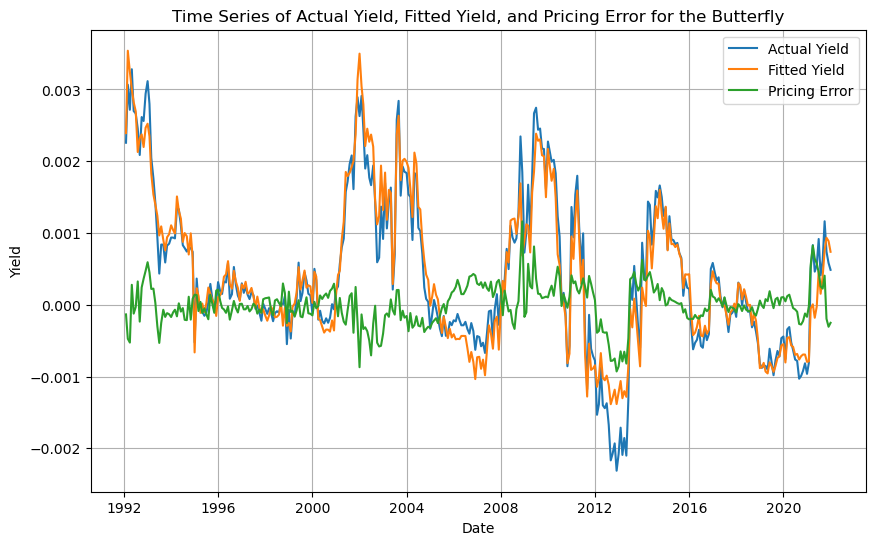

Statistics for the Butterfly Pricing Error:
Average Pricing Error: -0.000000
Average Absolute Pricing Error: 0.000210
Standard Deviation of Pricing Error: 0.000280
Autocorrelation of Pricing Error: 0.724336


In [21]:
# Compute the butterfly yield, fitted yield, and pricing error
butterfly_yield = paryields['US#05'] - 0.5 * paryields['US#02'] - 0.5 * paryields['US#10']
fitted_butterfly_yield = fitted_yields['US#05'] - 0.5 * fitted_yields['US#02'] - 0.5 * fitted_yields['US#10']
butterfly_pricing_error = butterfly_yield - fitted_butterfly_yield

# Compute statistics for the butterfly pricing error
butterfly_avg_error = butterfly_pricing_error.mean()
butterfly_avg_abs_error = butterfly_pricing_error.abs().mean()
butterfly_std_dev_error = butterfly_pricing_error.std()
butterfly_autocorrelation = butterfly_pricing_error.autocorr()

# Plot the time series of actual yield, fitted yield, and pricing error for the butterfly
plt.figure(figsize=(10, 6))
plt.plot(butterfly_yield.index, butterfly_yield, label='Actual Yield')
plt.plot(fitted_butterfly_yield.index, fitted_butterfly_yield, label='Fitted Yield')
plt.plot(butterfly_pricing_error.index, butterfly_pricing_error, label='Pricing Error')
plt.title('Time Series of Actual Yield, Fitted Yield, and Pricing Error for the Butterfly')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# Print statistics for the butterfly pricing error
print("Statistics for the Butterfly Pricing Error:")
print(f"Average Pricing Error: {butterfly_avg_error:.6f}")
print(f"Average Absolute Pricing Error: {butterfly_avg_abs_error:.6f}")
print(f"Standard Deviation of Pricing Error: {butterfly_std_dev_error:.6f}")
print(f"Autocorrelation of Pricing Error: {butterfly_autocorrelation:.6f}")


In [22]:
# Define a function to perform regression and return results
def regression_analysis(dependent_variable, independent_variable):
    # Add constant term to independent variable
    independent_variable = sm.add_constant(independent_variable)
    
    # Fit OLS model
    model = sm.OLS(dependent_variable, independent_variable)
    results = model.fit()
    
    return results

# Get butterfly yield changes and lagged pricing errors
butterfly_yield_changes = butterfly_yield.diff().dropna()
lagged_butterfly_pricing_errors = butterfly_pricing_error.shift(1).dropna()

# Regression of actual yield changes on lagged pricing errors for the butterfly
results_actual_yield_changes = regression_analysis(butterfly_yield_changes, lagged_butterfly_pricing_errors)

# Regression of fitted yield changes on lagged pricing errors for the butterfly
fitted_butterfly_yield_changes = fitted_butterfly_yield.diff().dropna()
results_fitted_yield_changes = regression_analysis(fitted_butterfly_yield_changes, lagged_butterfly_pricing_errors)

# Print regression results
print("Regression Results - Actual Yield Changes on Lagged Pricing Errors (Butterfly):")
print(results_actual_yield_changes.summary())

print("\nRegression Results - Fitted Yield Changes on Lagged Pricing Errors (Butterfly):")
print(results_fitted_yield_changes.summary())


Regression Results - Actual Yield Changes on Lagged Pricing Errors (Butterfly):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     13.67
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           0.000252
Time:                        19:22:13   Log-Likelihood:                 2289.4
No. Observations:                 359   AIC:                            -4575.
Df Residuals:                     357   BIC:                            -4567.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [23]:
#  Calculate return series for duration-neutral butterfly
return_series_dur = returns['US#05'] - 0.5 * returns['US#02'] - 0.5 * returns['US#10']

# Solve linear equations to find c2 and c10 for PCA neutral butterfly
A = np.array([[1, -0.5], [0, -10]])
b = np.array([0, 0])  # Zero loading on the level and slope factors
c2, c10 = np.linalg.solve(A, b)
# Calculate return series for PCA neutral butterfly
return_series_pca = returns['US#05'] - c2 * returns['US#02'] - c10 * returns['US#10']

# Calculate annualized average, annualized standard deviation, and annualized Sharpe ratio
annualized_average_dur = return_series_dur.mean() * 252  # Assuming 252 trading days in a year
annualized_std_dev_dur = return_series_dur.std() * np.sqrt(252)
sharpe_ratio_dur = annualized_average_dur / annualized_std_dev_dur

annualized_average_pca = return_series_pca.mean() * 252
annualized_std_dev_pca = return_series_pca.std() * np.sqrt(252)
sharpe_ratio_pca = annualized_average_pca / annualized_std_dev_pca

# Print the results
print("Duration-Neutral Butterfly:")
print("Annualized Average:", annualized_average_dur)
print("Annualized Standard Deviation:", annualized_std_dev_dur)
print("Annualized Sharpe Ratio:", sharpe_ratio_dur)

print("\nPCA Neutral Butterfly:")
print("Annualized Average:", annualized_average_pca)
print("Annualized Standard Deviation:", annualized_std_dev_pca)
print("Annualized Sharpe Ratio:", sharpe_ratio_pca)

Duration-Neutral Butterfly:
Annualized Average: -0.004717029758968591
Annualized Standard Deviation: 0.025394914311098648
Annualized Sharpe Ratio: -0.1857470240372912

PCA Neutral Butterfly:
Annualized Average: 0.526606575240058
Annualized Standard Deviation: 0.1889541251764134
Annualized Sharpe Ratio: 2.7869546364674593


In [24]:
# Z-Score
# Compute the z-score of the pricing error
pricing_error_zscore = (butterfly_pricing_error) / butterfly_pricing_error.std()

# Truncate the z-score at +/- 2
pricing_error_zscore = np.clip(pricing_error_zscore, -2, 2)

In [25]:
pricing_error_zscore

Date
1992-01-31   -0.479360
1992-02-28   -1.691155
1992-03-31   -1.881660
1992-04-30    0.994193
1992-05-29   -0.440242
                ...   
2021-08-31    0.805695
2021-09-30    1.448375
2021-10-29   -0.695613
2021-11-30   -1.093415
2021-12-31   -0.898303
Length: 360, dtype: float64

In [26]:
pricing_error_zscore

Date
1992-01-31   -0.479360
1992-02-28   -1.691155
1992-03-31   -1.881660
1992-04-30    0.994193
1992-05-29   -0.440242
                ...   
2021-08-31    0.805695
2021-09-30    1.448375
2021-10-29   -0.695613
2021-11-30   -1.093415
2021-12-31   -0.898303
Length: 360, dtype: float64

In [27]:
# Compute excess returns for the duration-neutral strategy
k_dur = 0.1 / (pricing_error_zscore.std() * np.sqrt(252))
excess_returns_dur = k_dur * pricing_error_zscore.shift(1) * return_series_dur

# Compute excess returns for the PCA-neutral strategy
k_pca = 0.1 / (pricing_error_zscore.std() * np.sqrt(252))
excess_returns_pca = k_pca * pricing_error_zscore.shift(1) * return_series_pca

# Compute annualized average excess return, annualized standard deviation,
# annualized Sharpe ratio, skewness, and kurtosis for both strategies
annualized_avg_excess_return_dur = excess_returns_dur.mean() * 252
annualized_std_dev_dur = excess_returns_dur.std() * np.sqrt(252)
sharpe_ratio_dur = annualized_avg_excess_return_dur / annualized_std_dev_dur
skewness_dur = excess_returns_dur.skew()
kurtosis_dur = excess_returns_dur.kurtosis()

annualized_avg_excess_return_pca = excess_returns_pca.mean() * 252
annualized_std_dev_pca = excess_returns_pca.std() * np.sqrt(252)
sharpe_ratio_pca = annualized_avg_excess_return_pca / annualized_std_dev_pca
skewness_pca = excess_returns_pca.skew()
kurtosis_pca = excess_returns_pca.kurtosis()

# Print the results
print("Duration-Neutral Strategy:")
print("Annualized Average Excess Return:", annualized_avg_excess_return_dur)
print("Annualized Standard Deviation:", annualized_std_dev_dur)
print("Annualized Sharpe Ratio:", sharpe_ratio_dur)
print("Skewness of Returns:", skewness_dur)
print("Kurtosis of Returns:", kurtosis_dur)

print("\nPCA Neutral Strategy:")
print("Annualized Average Excess Return:", annualized_avg_excess_return_pca)
print("Annualized Standard Deviation:", annualized_std_dev_pca)
print("Annualized Sharpe Ratio:", sharpe_ratio_pca)
print("Skewness of Returns:", skewness_pca)
print("Kurtosis of Returns:", kurtosis_pca)

Duration-Neutral Strategy:
Annualized Average Excess Return: 0.0006152876813674568
Annualized Standard Deviation: 0.00018147253683008756
Annualized Sharpe Ratio: 3.3905278017000975
Skewness of Returns: 1.7955892537767728
Kurtosis of Returns: 8.353221918394796

PCA Neutral Strategy:
Annualized Average Excess Return: 0.002767392049431693
Annualized Standard Deviation: 0.0013229346658219024
Annualized Sharpe Ratio: 2.091858442391325
Skewness of Returns: 1.9049612787514902
Kurtosis of Returns: 16.05104656095174


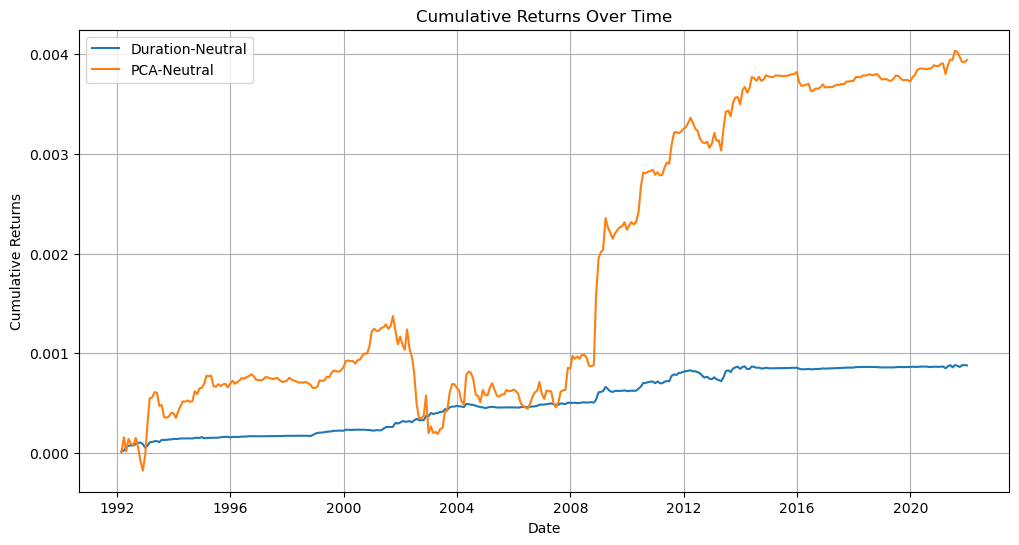

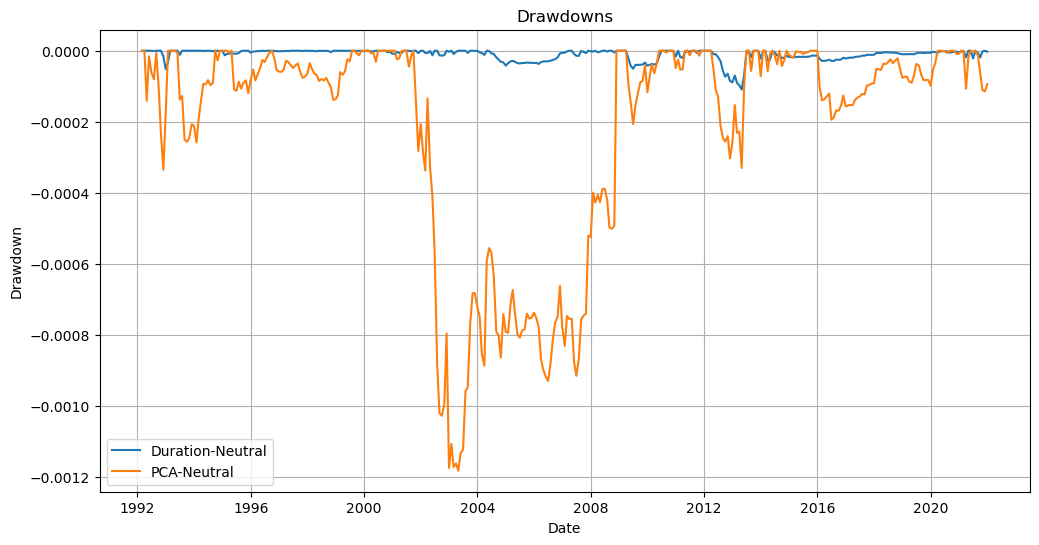

In [28]:
import matplotlib.pyplot as plt

# Calculate cumulative returns
cumulative_returns_dur = excess_returns_dur.cumsum()
cumulative_returns_pca = excess_returns_pca.cumsum()

# Calculate drawdowns
drawdowns_dur = cumulative_returns_dur - cumulative_returns_dur.cummax()
drawdowns_pca = cumulative_returns_pca - cumulative_returns_pca.cummax()

# Plot cumulative returns over time
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_dur.index, cumulative_returns_dur, label='Duration-Neutral')
plt.plot(cumulative_returns_pca.index, cumulative_returns_pca, label='PCA-Neutral')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(drawdowns_dur.index, drawdowns_dur, label='Duration-Neutral')
plt.plot(drawdowns_pca.index, drawdowns_pca, label='PCA-Neutral')
plt.title('Drawdowns')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
# Problem 8 
correlation = excess_returns_dur.corr(excess_returns_pca)
# Run multiple regression for the duration-neutral strategy
X_dur = returns[['US#02', 'US#05', 'US#10']].mean(axis=1).diff().dropna()  # Level returns
Y_dur = returns['US#10'] - returns['US#02']  # Slope returns
Y_dur = Y_dur.iloc[1:]
X_dur = sm.add_constant(X_dur)

# Run multiple regression for the PCA-neutral strategy
X_pca = returns[['US#02', 'US#05', 'US#10']].mean(axis=1).diff().dropna()  # Level returns
Y_pca = returns['US#10'] - returns['US#02']  # Slope returns
Y_pca = Y_pca.iloc[1:]
X_pca = sm.add_constant(X_pca)

# Print the correlation of the two implementations
print("Correlation between the two implementations:", correlation)

# Reset indices for Y_dur and X_dur
Y_dur = Y_dur.reset_index(drop=True)
X_dur = X_dur.reset_index(drop=True)

# Reset indices for Y_pca and X_pca
Y_pca = Y_pca.reset_index(drop=True)
X_pca = X_pca.reset_index(drop=True)

# Run multiple regression for the duration-neutral strategy
model_dur = sm.OLS(Y_dur, X_dur)
results_dur = model_dur.fit()

# Run multiple regression for the PCA-neutral strategy
model_pca = sm.OLS(Y_pca, X_pca)
results_pca = model_pca.fit()

# Print regression results for the duration-neutral strategy
print("\nRegression Results - Duration-Neutral Strategy:")
print(results_dur.summary())

# Print regression results for the PCA-neutral strategy
print("\nRegression Results - PCA-Neutral Strategy:")
print(results_pca.summary())


Correlation between the two implementations: 0.5347118941494273

Regression Results - Duration-Neutral Strategy:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.009106
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.924
Time:                        19:42:50   Log-Likelihood:                 1310.5
No. Observations:                 358   AIC:                            -2617.
Df Residuals:                     356   BIC:                            -2609.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [42]:
# Define the maturities in years
maturities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
threefactors = centered_yields @ Q_df.iloc[:, :3]
fitted_yields_threefactors = threefactors @ Q_df.iloc[:, :3].T

# Compute pricing errors for each maturity
pricing_errors = paryields.sub(fitted_yields_threefactors)

# Select pricing errors for each maturity
pricing_errors_at_maturities = pricing_errors[[f'US#{maturity:02d}' for maturity in maturities]]

# Rename columns to indicate maturity
pricing_errors_at_maturities.columns = maturities

# Convert to DataFrame
pricing_errors_df_threefactors = pd.DataFrame(pricing_errors_at_maturities)

In [43]:
pricing_errors_df_threefactors

,1,2,3,4,5,6,7,8,9,10
Date,,,,,,,,,,
1992-01-31,0.030549,0.035102,0.035935,0.036715,0.039925,0.041200,0.042307,0.043032,0.043763,0.044206
1992-02-28,0.031092,0.033428,0.036585,0.038726,0.039009,0.040469,0.041868,0.042913,0.043920,0.044724
1992-03-31,0.030899,0.033882,0.036457,0.038574,0.039284,0.040281,0.041468,0.042830,0.044127,0.044929
1992-04-30,0.031183,0.033490,0.035991,0.038593,0.039669,0.040766,0.041867,0.042859,0.043835,0.044480
1992-05-29,0.031037,0.033717,0.036258,0.038374,0.039443,0.040663,0.041890,0.042884,0.043864,0.044604
...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.031086,0.033712,0.036123,0.038078,0.039695,0.040955,0.042025,0.042923,0.043722,0.044415
2021-09-30,0.031142,0.033653,0.035980,0.038100,0.039797,0.041064,0.042084,0.042924,0.043671,0.044319
2021-10-29,0.030906,0.034081,0.036195,0.037928,0.039507,0.040858,0.042005,0.042951,0.043791,0.044511


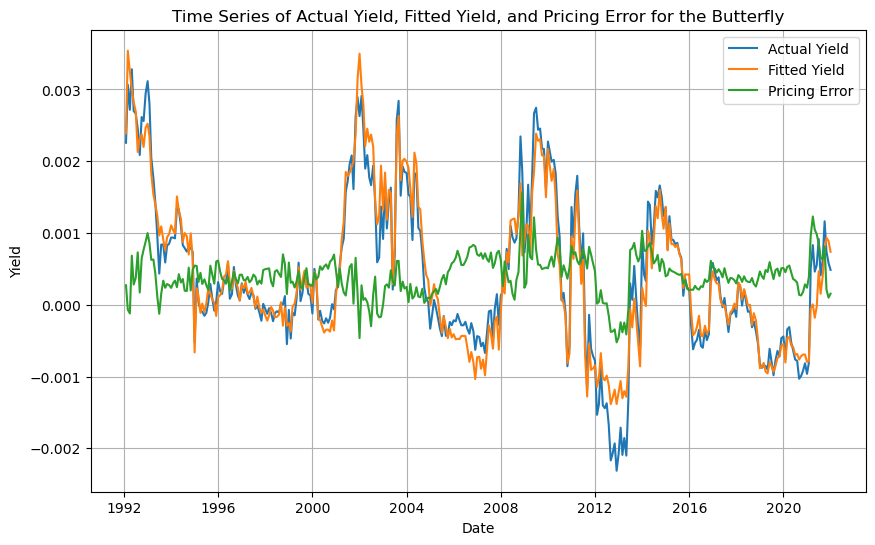

Statistics for the Butterfly Pricing Error:
Average Pricing Error: 0.000405
Average Absolute Pricing Error: 0.000434
Standard Deviation of Pricing Error: 0.000280
Autocorrelation of Pricing Error: 0.724336


In [44]:
#Problem 9
# Compute the butterfly yield, fitted yield, and pricing error
butterfly_yield = paryields['US#05'] - 0.5 * paryields['US#02'] - 0.5 * paryields['US#10']
fitted_butterfly_yield_threefactors = fitted_yields_threefactors['US#05'] - 0.5 * fitted_yields_threefactors['US#02'] - 0.5 * fitted_yields_threefactors['US#10']
butterfly_pricing_error = butterfly_yield - fitted_butterfly_yield_threefactors

# Compute statistics for the butterfly pricing error
butterfly_avg_error = butterfly_pricing_error.mean()
butterfly_avg_abs_error = butterfly_pricing_error.abs().mean()
butterfly_std_dev_error = butterfly_pricing_error.std()
butterfly_autocorrelation = butterfly_pricing_error.autocorr()

# Plot the time series of actual yield, fitted yield, and pricing error for the butterfly
plt.figure(figsize=(10, 6))
plt.plot(butterfly_yield.index, butterfly_yield, label='Actual Yield')
plt.plot(fitted_butterfly_yield.index, fitted_butterfly_yield, label='Fitted Yield')
plt.plot(butterfly_pricing_error.index, butterfly_pricing_error, label='Pricing Error')
plt.title('Time Series of Actual Yield, Fitted Yield, and Pricing Error for the Butterfly')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

# Print statistics for the butterfly pricing error
print("Statistics for the Butterfly Pricing Error:")
print(f"Average Pricing Error: {butterfly_avg_error:.6f}")
print(f"Average Absolute Pricing Error: {butterfly_avg_abs_error:.6f}")
print(f"Standard Deviation of Pricing Error: {butterfly_std_dev_error:.6f}")
print(f"Autocorrelation of Pricing Error: {butterfly_autocorrelation:.6f}")


In [45]:
#PROBLEM 10
# Define a function to perform regression and return results
def regression_analysis(dependent_variable, independent_variable):
    # Add constant term to independent variable
    independent_variable = sm.add_constant(independent_variable)
    
    # Fit OLS model
    model = sm.OLS(dependent_variable, independent_variable)
    results = model.fit()
    
    return results

# Get butterfly yield changes and lagged pricing errors
butterfly_yield_changes = butterfly_yield.diff().dropna()
lagged_butterfly_pricing_errors = butterfly_pricing_error.shift(1).dropna()

# Regression of actual yield changes on lagged pricing errors for the butterfly
results_actual_yield_changes = regression_analysis(butterfly_yield_changes, lagged_butterfly_pricing_errors)

# Regression of fitted yield changes on lagged pricing errors for the butterfly
fitted_butterfly_yield_threefactors_changes = fitted_butterfly_yield_threefactors.diff().dropna()
results_fitted_yield_changes = regression_analysis(fitted_butterfly_yield_threefactors_changes, lagged_butterfly_pricing_errors)

# Print regression results
print("Regression Results (3 factors) - Actual Yield Changes on Lagged Pricing Errors (Butterfly):")
print(results_actual_yield_changes.summary())

print("\nRegression Results (3 factors) - Fitted Yield Changes on Lagged Pricing Errors (Butterfly):")
print(results_fitted_yield_changes.summary())


Regression Results (3 factors) - Actual Yield Changes on Lagged Pricing Errors (Butterfly):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     13.67
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           0.000252
Time:                        20:01:23   Log-Likelihood:                 2289.4
No. Observations:                 359   AIC:                            -4575.
Df Residuals:                     357   BIC:                            -4567.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [46]:
# Problem 11 Z-Score
# Compute the z-score of the pricing error
pricing_error_zscore = (butterfly_pricing_error) / butterfly_pricing_error.std()

# Truncate the z-score at +/- 2
pricing_error_zscore = np.clip(pricing_error_zscore, -2, 2)

In [47]:
pricing_error_zscore

Date
1992-01-31    0.969333
1992-02-28   -0.242462
1992-03-31   -0.432967
1992-04-30    2.000000
1992-05-29    1.008451
                ...   
2021-08-31    2.000000
2021-09-30    2.000000
2021-10-29    0.753080
2021-11-30    0.355277
2021-12-31    0.550390
Length: 360, dtype: float64

In [48]:
# Problem 11
#  Calculate return series for duration-neutral butterfly
return_series_dur = returns['US#05'] - 0.5 * returns['US#02'] - 0.5 * returns['US#10']

# Solve linear equations to find c2 and c10 for PCA neutral butterfly
A = np.array([[1, -0.5], [0, -10]])
b = np.array([0, 0])  # Zero loading on the level and slope factors
c2, c10 = np.linalg.solve(A, b)
# Calculate return series for PCA neutral butterfly
return_series_pca = returns['US#05'] - c2 * returns['US#02'] - c10 * returns['US#10']

# Calculate annualized average, annualized standard deviation, and annualized Sharpe ratio
annualized_average_dur = return_series_dur.mean() * 252  # Assuming 252 trading days in a year
annualized_std_dev_dur = return_series_dur.std() * np.sqrt(252)
sharpe_ratio_dur = annualized_average_dur / annualized_std_dev_dur

annualized_average_pca = return_series_pca.mean() * 252
annualized_std_dev_pca = return_series_pca.std() * np.sqrt(252)
sharpe_ratio_pca = annualized_average_pca / annualized_std_dev_pca

# Print the results
print("Duration-Neutral Butterfly:")
print("Annualized Average:", annualized_average_dur)
print("Annualized Standard Deviation:", annualized_std_dev_dur)
print("Annualized Sharpe Ratio:", sharpe_ratio_dur)

print("\nPCA Neutral Butterfly:")
print("Annualized Average:", annualized_average_pca)
print("Annualized Standard Deviation:", annualized_std_dev_pca)
print("Annualized Sharpe Ratio:", sharpe_ratio_pca)

# Compute excess returns for the duration-neutral strategy
k_dur = 0.1 / (pricing_error_zscore.std() * np.sqrt(252))
excess_returns_dur = k_dur * pricing_error_zscore.shift(1) * return_series_dur

# Compute excess returns for the PCA-neutral strategy
k_pca = 0.1 / (pricing_error_zscore.std() * np.sqrt(252))
excess_returns_pca = k_pca * pricing_error_zscore.shift(1) * return_series_pca

# Compute annualized average excess return, annualized standard deviation,
# annualized Sharpe ratio, skewness, and kurtosis for both strategies
annualized_avg_excess_return_dur = excess_returns_dur.mean() * 252
annualized_std_dev_dur = excess_returns_dur.std() * np.sqrt(252)
sharpe_ratio_dur = annualized_avg_excess_return_dur / annualized_std_dev_dur
skewness_dur = excess_returns_dur.skew()
kurtosis_dur = excess_returns_dur.kurtosis()

annualized_avg_excess_return_pca = excess_returns_pca.mean() * 252
annualized_std_dev_pca = excess_returns_pca.std() * np.sqrt(252)
sharpe_ratio_pca = annualized_avg_excess_return_pca / annualized_std_dev_pca
skewness_pca = excess_returns_pca.skew()
kurtosis_pca = excess_returns_pca.kurtosis()

# Print the results
print("Duration-Neutral Strategy:")
print("Annualized Average Excess Return:", annualized_avg_excess_return_dur)
print("Annualized Standard Deviation:", annualized_std_dev_dur)
print("Annualized Sharpe Ratio:", sharpe_ratio_dur)
print("Skewness of Returns:", skewness_dur)
print("Kurtosis of Returns:", kurtosis_dur)

print("\nPCA Neutral Strategy:")
print("Annualized Average Excess Return:", annualized_avg_excess_return_pca)
print("Annualized Standard Deviation:", annualized_std_dev_pca)
print("Annualized Sharpe Ratio:", sharpe_ratio_pca)
print("Skewness of Returns:", skewness_pca)
print("Kurtosis of Returns:", kurtosis_pca)

Duration-Neutral Butterfly:
Annualized Average: -0.004717029758968591
Annualized Standard Deviation: 0.025394914311098648
Annualized Sharpe Ratio: -0.1857470240372912

PCA Neutral Butterfly:
Annualized Average: 0.526606575240058
Annualized Standard Deviation: 0.1889541251764134
Annualized Sharpe Ratio: 2.7869546364674593
Duration-Neutral Strategy:
Annualized Average Excess Return: 0.0004446752763085044
Annualized Standard Deviation: 0.00032285703577391005
Annualized Sharpe Ratio: 1.3773132595440822
Skewness of Returns: 0.30679129205334515
Kurtosis of Returns: 4.402773232519935

PCA Neutral Strategy:
Annualized Average Excess Return: 0.007436303750120898
Annualized Standard Deviation: 0.002278087088764427
Annualized Sharpe Ratio: 3.264275447061222
Skewness of Returns: 0.7415834703491827
Kurtosis of Returns: 3.097052245395977


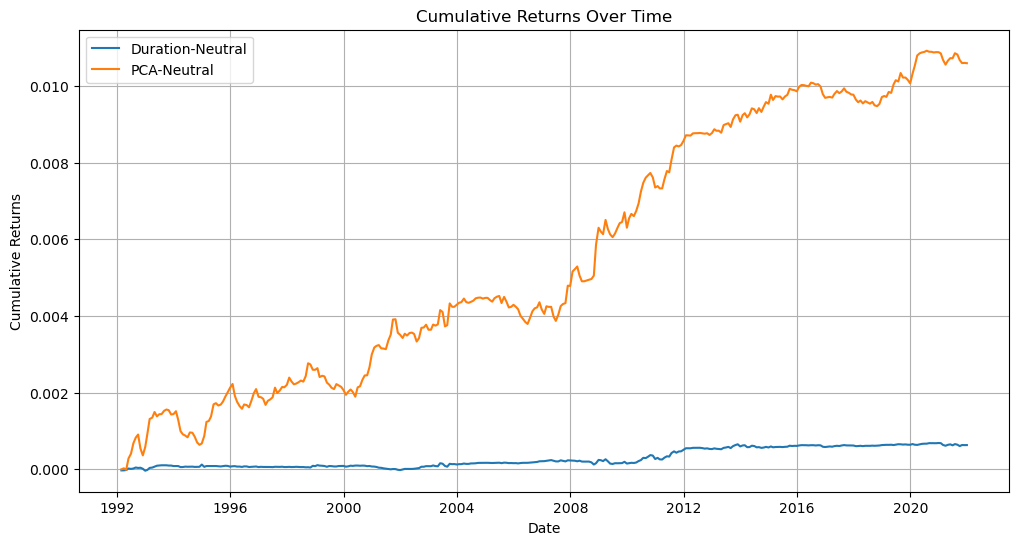

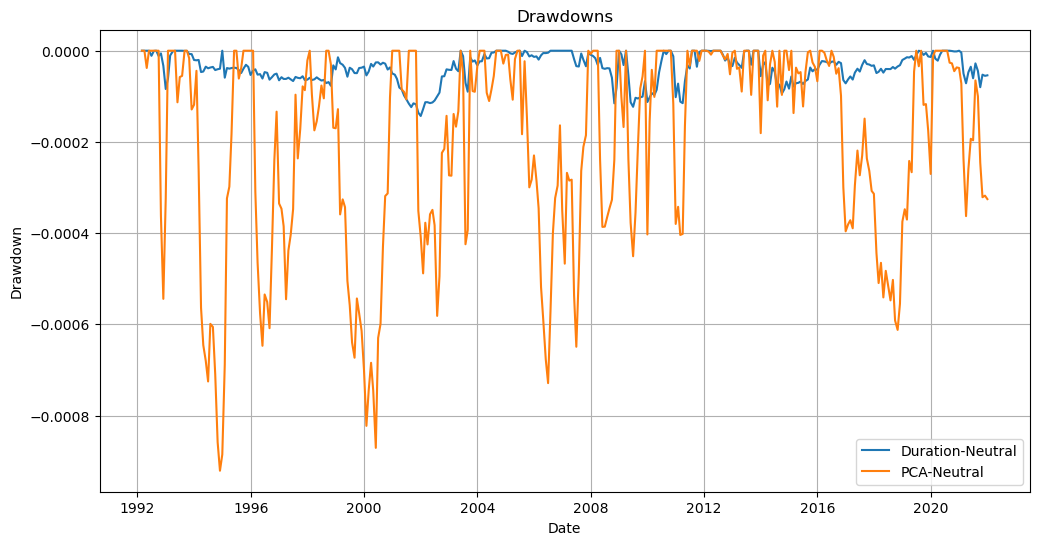

In [50]:
#Problem 11 cumulative returns and max drawdown

# Calculate cumulative returns
cumulative_returns_dur = excess_returns_dur.cumsum()
cumulative_returns_pca = excess_returns_pca.cumsum()

# Calculate drawdowns
drawdowns_dur = cumulative_returns_dur - cumulative_returns_dur.cummax()
drawdowns_pca = cumulative_returns_pca - cumulative_returns_pca.cummax()

# Plot cumulative returns over time
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_dur.index, cumulative_returns_dur, label='Duration-Neutral')
plt.plot(cumulative_returns_pca.index, cumulative_returns_pca, label='PCA-Neutral')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(drawdowns_dur.index, drawdowns_dur, label='Duration-Neutral')
plt.plot(drawdowns_pca.index, drawdowns_pca, label='PCA-Neutral')
plt.title('Drawdowns')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Problem 12
# Compute pricing errors for the 2y-3y-5y butterfly
butterfly_2y_3y_5y = paryields['US#03'] - 0.5 * paryields['US#02'] - 0.5 * paryields['US#05']
pricing_errors_2y_3y_5y = butterfly_2y_3y_5y - fitted_yields

# Compute pricing errors for the 5y-7y-10y butterfly
butterfly_5y_7y_10y = paryields['US#07'] - 0.5 * paryields['US#05'] - 0.5 * paryields['US#10']
pricing_errors_5y_7y_10y = butterfly_5y_7y_10y - fitted_yields
